In [207]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max

%matplotlib inline

## Question 1

In [168]:
def laplace_of_gaussian(sigma):
    hw = round(3*sigma)    # Half width of kernel
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))

    log = ((X**2 + Y**2)/(2*sigma**2) - 1) * np.exp(-(X**2 + Y**2)/(2*sigma**2)) / (np.pi * sigma**4)
    return log

In [200]:
def detect_max(img_log, sigma):
    coordinates = []
    (h, w) = img_log.shape
    k = 1
    for i in range(k, h-k):
        for j in range(k, w-k):
            slice_img = img_log[i-k:i+k+1, j-k:j+k+1]
            result = np.max(slice_img) # finding maximum
            if result >= 0.09: # threshold
                x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                coordinates.append((i+x-k, j+y-k)) #finding co-rdinates
    return set(coordinates)

(-27.425, 359.5, 359.5, -0.5)

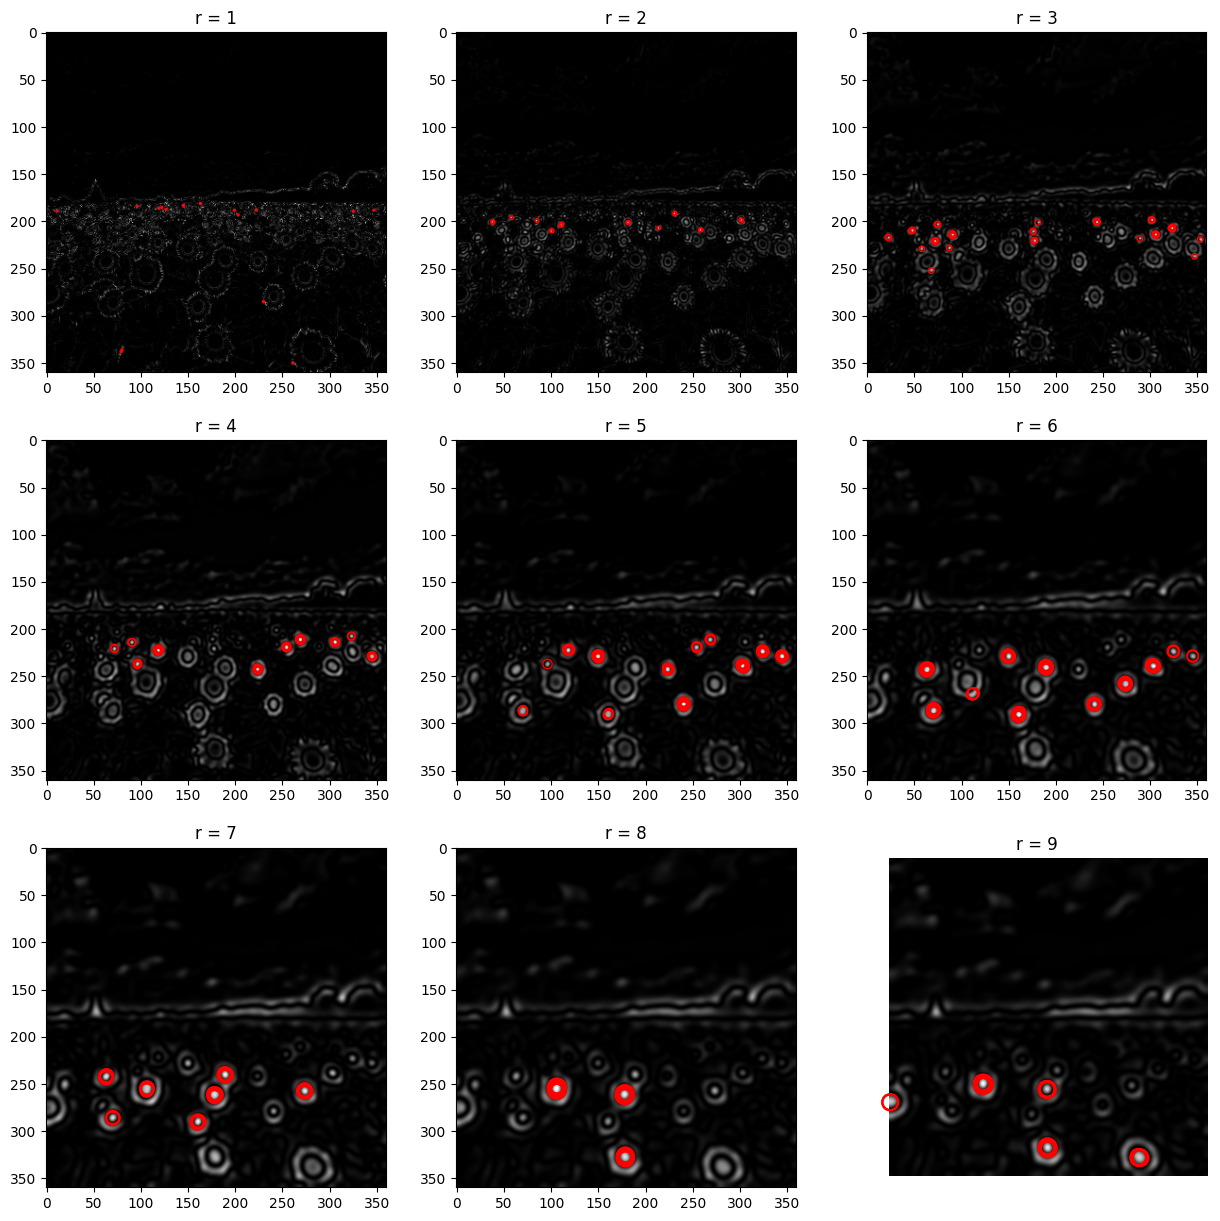

In [218]:
img1 = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255

fig, axes = plt.subplots(3, 3, figsize = (15, 15))

for r, ax in enumerate(axes.flatten(), start = 1):
    sigma = r/1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)
    img1_log = np.square(cv.filter2D(img1, -1, LOG))

    coordinates = detect_max(img1_log, sigma)

    ax.imshow(img1_log, cmap = 'gray')
    ax.set_title(f'r = {r}')

    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color = 'red', linewidth=1, fill=False)
        ax.add_patch(c)
    ax.plot()

plt.axis('off')

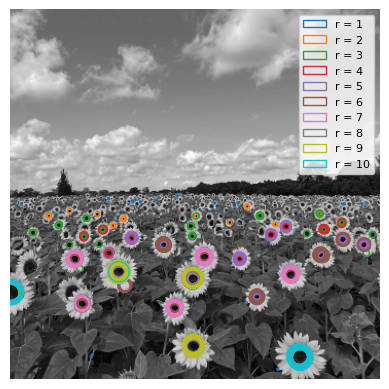

In [229]:
fig, ax = plt.subplots()
ax.imshow(img1, cmap = 'gray')
ax.grid(False)
colors = list(mcolors.TABLEAU_COLORS)

patches = []
labels = []

for r in range(1, 11):
    sigma = r/1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)
    img1_log = np.square(cv.filter2D(img1, -1, LOG))

    coordinates = detect_max(img1_log, sigma)

    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color = colors[r-1], linewidth=1, fill=False)
        ax.add_patch(c)
    patches.append(c)
    labels.append(f'r = {r}')
    ax.plot()
ax.set_xlim(0, img1.shape[1])

plt.axis('off')
ax.legend(patches, labels, loc='best', fontsize=8)


## Question 2

<AxesSubplot: >

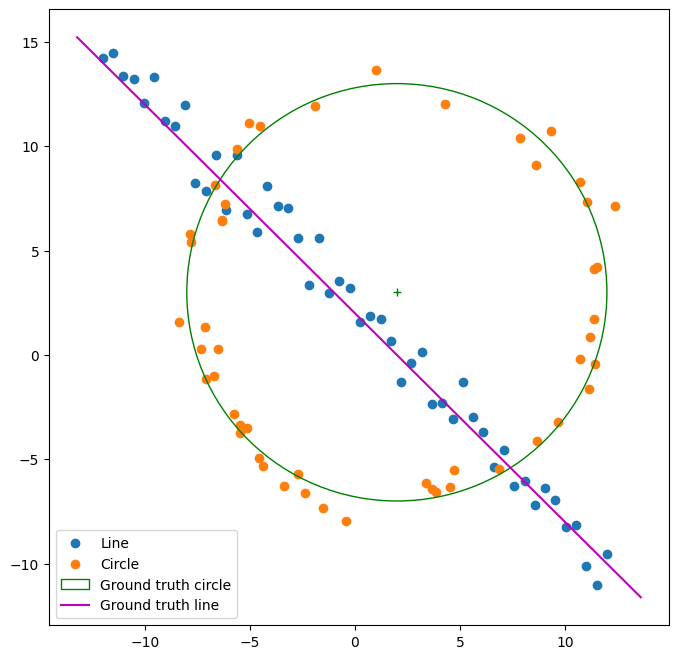

In [423]:
# Generating noisy point set

from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

# Set random seed
np.random.seed(0)

# Constants
N = 100
half_n = N // 2

# Parameters
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plotting
def plot_all():
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
    ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()


In [416]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def line_eq(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    a = (y2 - y1)
    b = -(x2 - x1)
    d = a*x1 + b*y1
    assert abs(a*x2 + b*y2 - d) < 1e-8

    # Apply constraint
    norm = (a**2 + b**2)**0.5
    a, b, d = a/norm, b/norm, d/norm
    return a, b, d

def circle_eq(p1, p2, p3):
    (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
    
    # circumcenter of circle is equidistant to all points
    mx1, my1 = (x1 + x2)/2, (y1 + y2)/2
    mx2, my2 = (x1 + x3)/2, (y1 + y3)/2

    s1 = -(x2 - x1)/(y2 - y1)
    s2 = -(x3 - x1)/(y3 - y1)

    c1 = my1 - s1 * mx1
    c2 = my2 - s2 * mx2

    cx = (c2 - c1)/(s1 - s2)
    cy = s1 * cx + c1
    assert abs(s2 * cx + c2 - cy) < 1e-8

    r = dist((cx, cy), p1)
    assert abs(dist((cx, cy), p2) - dist((cx, cy), p1)) < 1e-8
    return cx, cy, r
    

In [462]:
def tls_error_line(params, *args):
    # Error of points denoted by indices, params is the one that should be optimized
    a, b, d = params
    indices, X = args
    error = np.sum((a * X[indices, 0] + b * X[indices, 1] - d)**2)
    return error

def tls_error_circle(params, *args):
    cx, cy, r = params
    indices, X = args
    error = np.sum((dist((cx, cy), (X[indices, 0], X[indices, 1])) - r)**2)
    return error

In [463]:
def consensus_line(params, thres, X):   # Whether each point is an inlier
    a, b, d = params
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return np.where(errors < thres)

def consensus_circle(params, thres, X):   # Whether each point is an inlier
    cx, cy, r = params
    errors = np.abs(dist((cx, cy), (X[:, 0], X[:, 1])) - r) # radial error
    return np.where(errors < thres)

def constraint(params): # Should be equal to zero
    a, b, d = params
    return (a**2 + b**2)**0.5 - 1

constraint_dict = {'type':'eq', 'fun':constraint}

def least_squares_line_fit(indices, initial, X):  # line fitting with scipy minimize
    res = minimize(fun=tls_error_line, x0=initial, args=(indices, X), constraints=constraint_dict, tol=1e-6)
    print(res.x, res.fun)
    return res

def least_squares_circ_fit(indices, initial, X):
    res = minimize(fun=tls_error_circle, x0=initial, args=(indices, X), tol=1e-6)
    print(res.x, res.fun)
    return res

In [438]:
# Fitting the line

iters = 100
min_points = 2
N = X.shape[0]
np.random.seed(14)

thres = 1.   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_line = None
best_fitted_line = None
best_error = np.inf
best_line_inliers = None
best_line_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(0, N), size=min_points, replace=False)
    params = line_eq(X[indices[0]], X[indices[1]])
    inliers = consensus_line(params, thres, X)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:   # compute again 
        res = least_squares_line_fit(inliers, params, X)
        if res.fun < best_error:
            best_error = res.fun
            best_model_line = params
            best_fitted_line = res.x
            best_line_inliers = inliers
            best_sample_points = indices

line_inliers = consensus_line(best_fitted_line, 1.2, X)[0]

print(f'Best line = {best_fitted_line}, No. of inliers = {len(line_inliers)}, best_error = {best_error}')
    

Iteration 0: No. of inliers = 9
Iteration 1: No. of inliers = 34
Iteration 2: No. of inliers = 4
Iteration 3: No. of inliers = 16
Iteration 4: No. of inliers = 6
Iteration 5: No. of inliers = 12
Iteration 6: No. of inliers = 11
Iteration 7: No. of inliers = 8
Iteration 8: No. of inliers = 12
Iteration 9: No. of inliers = 15
Iteration 10: No. of inliers = 5
Iteration 11: No. of inliers = 8
Iteration 12: No. of inliers = 37
Iteration 13: No. of inliers = 12
Iteration 14: No. of inliers = 21
Iteration 15: No. of inliers = 8
Iteration 16: No. of inliers = 10
Iteration 17: No. of inliers = 16
Iteration 18: No. of inliers = 12
Iteration 19: No. of inliers = 23
Iteration 20: No. of inliers = 29
Iteration 21: No. of inliers = 6
Iteration 22: No. of inliers = 39
Iteration 23: No. of inliers = 38
Iteration 24: No. of inliers = 10
Iteration 25: No. of inliers = 4
Iteration 26: No. of inliers = 22
Iteration 27: No. of inliers = 40
[0.71205467 0.70212402 1.53281698] 8.09865025050975
Iteration 28: N

In [486]:
# fitting the circle

remaining_points = np.array([i for i in range(N) if i not in line_inliers])
X_rem = X[remaining_points]

iters = 100
min_points = 3  # We need 3 points to estimate a circle

thres = 1.2   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_circle = None
best_fitted_circle = None
best_error = np.inf
best_circ_inliers = None
best_circ_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(len(X_rem)), size=min_points, replace=False)
    params = circle_eq(*X_rem[indices])
    inliers = consensus_circle(params, thres, X_rem)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:   # compute again 
        res = least_squares_circ_fit(inliers, params, X_rem)
        if res.fun < best_error:
            best_error = res.fun
            best_model_circle = params
            best_fitted_circle = res.x
            best_circ_inliers = inliers
            best_circ_sample_points = indices

circ_inliers = consensus_circle(best_fitted_circle, thres, X_rem)[0]

print(f'Best circle = {best_fitted_circle}, No. of inliers = {len(circ_inliers)}, best_error = {best_error}')

Iteration 0: No. of inliers = 7
Iteration 1: No. of inliers = 4
Iteration 2: No. of inliers = 10
Iteration 3: No. of inliers = 31
Iteration 4: No. of inliers = 8
Iteration 5: No. of inliers = 34
Iteration 6: No. of inliers = 13
Iteration 7: No. of inliers = 14
Iteration 8: No. of inliers = 42
[1.88662053 2.8490593  9.7382417 ] 9.714278363734888
Iteration 9: No. of inliers = 12
Iteration 10: No. of inliers = 15
Iteration 11: No. of inliers = 23
Iteration 12: No. of inliers = 7
Iteration 13: No. of inliers = 13
Iteration 14: No. of inliers = 30
Iteration 15: No. of inliers = 22
Iteration 16: No. of inliers = 7
Iteration 17: No. of inliers = 37
Iteration 18: No. of inliers = 19
Iteration 19: No. of inliers = 16
Iteration 20: No. of inliers = 11
Iteration 21: No. of inliers = 23
Iteration 22: No. of inliers = 32
Iteration 23: No. of inliers = 15
Iteration 24: No. of inliers = 9
Iteration 25: No. of inliers = 9
Iteration 26: No. of inliers = 31
Iteration 27: No. of inliers = 7
Iteration 28:

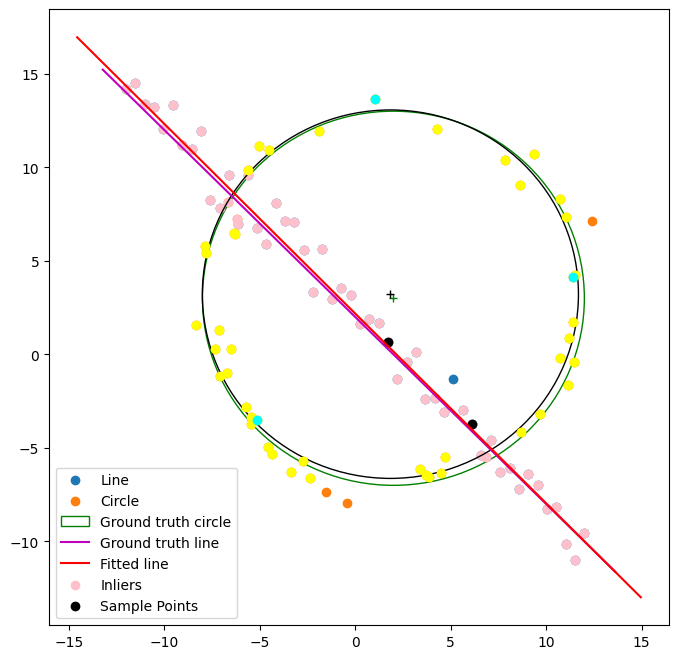

In [487]:
ax = plot_all()

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
A, B, D = best_fitted_line
indices = line_inliers

y_ = (D - A*x_) / B
plt.plot(x_, y_, color='r', label='Fitted line')
ax.scatter(X[indices, 0], X[indices, 1], color = 'pink', label = "Inliers")
ax.scatter(X[best_sample_points, 0], X[best_sample_points, 1], color = 'black', label = "Sample Points")
plt.legend()

x0, y0, r0 = best_fitted_circle
circle_gt = plt.Circle((x0, y0), r0, color='black', fill=False, label='RANSAC circle')
ax.add_patch(circle_gt)
ax.plot(x0, y0, '+', color='black')

ax.scatter(X_rem[circ_inliers, 0], X_rem[circ_inliers, 1], color = 'yellow', label = "Circle Inliers")
ax.scatter(X_rem[best_circ_sample_points, 0], X_rem[best_circ_sample_points, 1], color = 'cyan', label = "Sample Points")

In [257]:
a*x2 + b*y2

1.7258169752610417

In [442]:
len(X_rem)

48

In [330]:
remaining_points = np.array([i for i in range(N) if i not in inliers])


In [413]:
params = circle_eq(X_circ[0], X_circ[13], X_circ[23])

9.619879860551276 9.619879860551276 9.619879860551274


In [415]:
consensus_circle(params, thres, X)

(array([ 8, 18, 20, 21, 23, 28, 31, 65, 68, 87], dtype=int64),)

In [338]:
X_circ[0], X_circ[13], X_circ[23]

(array([-6.51668467,  0.30278774]),
 array([11.16600473, -1.6271128 ]),
 array([ 3.85858914, -6.57008059]))

In [397]:
(x1, y1), (x2, y2), (x3, y3) = X_circ[10], X_circ[13], X_circ[23]


In [458]:
tls_error_circle([-708.50350436,  711.98445225, 1420.50351108], inliers, X_rem).dtype

[6.64033424e-07 1.88166239e-05 1.58267742e-04 2.46601985e-05
 2.32337887e-04 1.73227495e-03 1.83249679e-03 4.84900585e-04
 4.70786606e-03 6.73438604e-04 9.03330411e-05 9.70083152e-06
 1.76842825e-03 1.13951290e-04 1.83141735e-04 1.05729669e-05
 4.18883495e-04 1.78699596e-03 3.03151230e-04 4.47053854e-04
 2.12918513e-03 5.16499774e-04 2.39595522e-04 2.40507154e-04
 1.76693010e-04 1.14748028e-03 3.65908181e-04 1.65913782e-03
 2.67459917e-04 2.50633059e-03 1.66134469e-05 9.49146952e-06
 2.13706331e-04 1.95101445e-04 2.10668624e-04 6.93039125e-04
 8.61976140e-05 4.73944339e-03 1.79304659e-03 1.34333175e-05
 3.37596867e-05 1.56594745e-04 1.55774944e-04 3.08757289e-05
 2.21772994e-04 2.68134121e-03 5.87382895e-03 9.45306097e-07]


dtype('float64')

In [ ]:
dist((-671.1584585, X_rem[[0, 1], 0]), (678.74961743, X_rem[[0,1], 1])) - r

In [452]:
np.sum((dist((-671.1584585, X_rem[[0, 1], 0]), (678.74961743, X_rem[[0,1], 1])) - r)**2)

3590809.5598312337

In [459]:
X_rem[inliers]

array([[-6.51668467,  0.30278774],
       [-0.43437105, -7.95194335],
       [-5.73249084, -2.82575284],
       [-7.34200103,  0.29333185],
       [-4.3802532 , -5.32148592],
       [-6.30877504,  6.43627445],
       [ 9.67227519, -3.2044032 ],
       [11.19535174,  0.86332008],
       [-5.61580776,  9.84793599],
       [ 4.50899099, -6.34996378],
       [-7.10987876,  1.32766754],
       [-7.08387069, -1.13900056],
       [11.16600473, -1.6271128 ],
       [11.05786244,  7.33454976],
       [10.69996536,  8.30351199],
       [11.52616119,  4.21671705],
       [ 3.6859591 , -6.43018707],
       [ 8.69218303, -4.12536112],
       [11.40625583,  1.72865949],
       [ 4.71186858, -5.49890104],
       [-7.81618803,  5.42333991],
       [ 3.85858914, -6.57008059],
       [ 8.6132303 ,  9.07666108],
       [-4.56254108, -4.92473923],
       [ 7.85832194, 10.39326675],
       [11.43226429, -0.41800553],
       [-8.35731761,  1.5691787 ],
       [ 1.02168118, 13.66735785],
       [ 3.39971155,

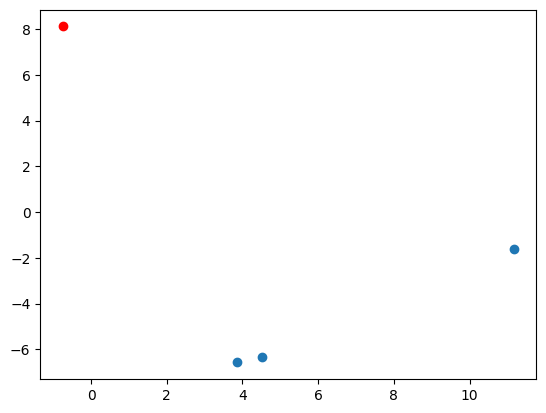

In [399]:
plt.scatter((x1, x2, x3), (y1, y2, y3))
plt.scatter(cx, cy, color = 'r')